# Exercises Chapter 5

1. What is the fundamental idea behind Support Vector Machines?

A: Identifying a n-1 hyperplane for a n-dimensional space (plus a margin, supported by some "support vectors" or observations) such that it splits the classes with the widest margin possible, while also minimising violations to the margin (observations located inside it or on the wrong side).

IN ADDITION: use of kernels when training non linear datasets (doing high-dimensional classification without actually increasing the dimensionality of the data).

2. What is a support vector

A: It's an observation that "supports" or defines the margin of the dividing hyperplane/decision boundary (it's located in the border or inside the two margins). Adding new training observations that are further away from the margin than the support vectors won't change the resulting margin (i.e. the decision boundary is entirely defined by the support vectors).

IN ADDITION: computing predictions only involves the support vectors, not the whole dataset.

3. Why is it important to scale the inputs when using SVMs?

A: Because the scale of the features determines how much weight they have in the cost function, so if a feature has a larger scale (just because of its measure units) then SVM will prioritise avoiding border crossings across that specific dimention, in detriment of the other dimentions. This is undesirable, so we scale all the features to receive the same weight by the SVM algorithm.

4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

A: For each observation, the SVM classifier outputs the result of a decision function, this value plus the boundary/cutoff determine the final predicted class. I think we could recover and look at that output, but it may be difficult to interpret, and certainly it's not a probability. 

IN ADDITION: sklearn CAN add probabilities to the model if we set the argument `probability=True`. It does that by training a logistic regression with cross validation that takes the scores (outputs of the decision function) as inputs and the class as output. This adds the method `predict_proba()` to the SVM model.

5. Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?

I would use the primal form because the dual form is faster in the opposite case (less training instances than features). However, I may want to use the dual form if I wanted to use the kernel trick for a high dimension boundary.

IN ADDITION: computational complexity of primal form is O(m) while dual form has compexity between m^2 and m^3, so primal form is best.

6. Say you’ve trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease γ (gamma)? What about C?

A: If the model is underfitting, I need to increase its flexibility (making it learn more about the training instances). C is "how much the model dislikes border crossings", so it should be increased. Gamma is the inverse of the range of influence of each observation in the similarity function. To increase the flexibility, gamma should be increased (thus making the similiarity function bell-shaped curve narrower).

7. How should you set the QP parameters (H, f, A, and b) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?

A: matrix [b] should be (zeta - 1) (but where do I specify that zeta should be equal or larger than zero?). Matrix [A] would be 1 + X (1 for the bias term) while [p] would be the parameters to estimate (main change here is incroporating the slack term zeta in [b]). 

In the minimisation part, fTp should be C\*sum(slacks), but the tricky part is that it should be built from the weights vector p? Maybe f could be something like C\*(slack_i)/weight_i so the weight term cancels out?

THIS WAS WRONG.

The soft margin is defined by increasing np. While in the hard margin problem np was the number of features + bias (n + 1), here it is n + 1 + m (one parameter extra per observation, which is the slack parameters). It also has m additional constrains (all slack paramaters being higher than zero).



8. Train a LinearSVC on a linearly separable dataset (DONE). Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

In [1]:
# Boilerplate code / load libraries
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
# Generate linearly separable dataset
x1 = np.absolute(np.random.randn(100))
y = np.concatenate([np.ones(50), np.zeros(50)])

In [3]:
# x2 = 3 times x1 if y =1 and 1.5 times if y = 0
x2 = np.concatenate([3+x1[:50] + np.random.normal(scale = 0.7, size = 50),
                     -1+x1[50:]+ np.random.normal(scale = 0.7, size = 50)])

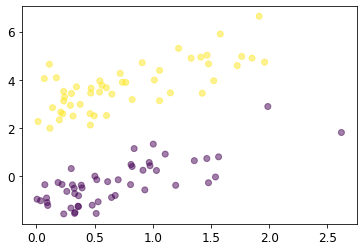

In [4]:
plt.scatter(x1, x2, c=y, alpha=0.5)

This is the linearly separable dataset I'm going to use with SVC

In [5]:
# Create the X
X = np.column_stack([x1, x2])

In [6]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline1 = Pipeline([('scaler', StandardScaler())])
X_scaled = pipeline1.fit_transform(X)

In [7]:
my_linearsvc = LinearSVC(random_state=0, tol=1e-05)
my_linearsvc.fit(X_scaled, y)

LinearSVC(random_state=0, tol=1e-05)

In [8]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    #svs = svm_clf.support_vectors_
    decision_function = svm_clf.decision_function(X_scaled)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    svs = X_scaled[support_vector_indices]
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

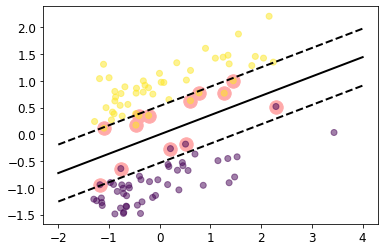

In [9]:
plot_svc_decision_boundary(my_linearsvc, -2, 4)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.5)

Now let's train an SVC model with kernel=="linear"

In [10]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="linear", C=0.35, tol=1e-05)
svm_clf.fit(X_scaled, y)

SVC(C=0.35, kernel='linear', tol=1e-05)

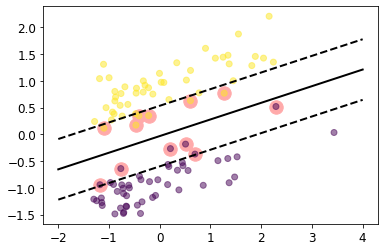

In [11]:
def plot_svc_decision_boundary_svc(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    
plot_svc_decision_boundary(svm_clf, -2, 4)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.5)

By tunning the `C` parameter they become very close, but there are still some small differences (there are two different support vectors for the yellow class).

Now let's try to fit the `SGDClassifier`:

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10000, tol=1e-7, alpha = 0.028)
sgd_clf.fit(X_scaled, y)

SGDClassifier(alpha=0.028, max_iter=10000, tol=1e-07)

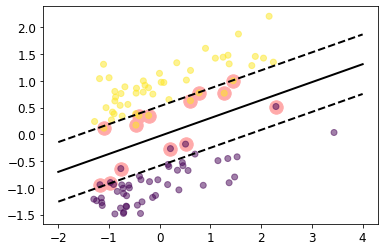

In [13]:
plot_svc_decision_boundary(sgd_clf, -2, 4)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.5)

Again, I could make them to become very close by adjusting the regularisation parameter (`alpha` in this case) but they're not exactly equal)

(I'll later see if there is a better approach in the exercises solutions)

9. Train a SVM classifier on the MNIST dataset

In [14]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [15]:
X, y = mnist["data"], mnist["target"]

In [16]:
# Not sure if I have to do this
y = y.astype(np.uint8)

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [18]:
# I'll try with the Gaussian RBF kernel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

rbf_kernel_svm_clf = Pipeline([("scaler", StandardScaler()),
                               ("svm_clf", SVC(kernel="rbf"))])

In [19]:
rbf_kernel_svm_clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'svm_clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'svm_clf__C', 'svm_clf__break_ties', 'svm_clf__cache_size', 'svm_clf__class_weight', 'svm_clf__coef0', 'svm_clf__decision_function_shape', 'svm_clf__degree', 'svm_clf__gamma', 'svm_clf__kernel', 'svm_clf__max_iter', 'svm_clf__probability', 'svm_clf__random_state', 'svm_clf__shrinking', 'svm_clf__tol', 'svm_clf__verbose'])

In [ ]:
# Random search of gamma and C
from sklearn.model_selection import RandomizedSearchCV

rbf_random = {'svm_clf__gamma': [0.001, 0.1, 1, 5, 10, 100, 1000],
               'svm_clf__C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]}

rf_random = RandomizedSearchCV(estimator = rbf_kernel_svm_clf,
                               param_distributions = rbf_random,
                               n_iter = 10,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
rf_random.best_params_